In [1]:
import pandas as pd
import bioframe
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

#### gtf data

In [2]:
def parse_gene_tx(series):
    gene_ids = []
    tx_ids = []
    external_gene_names = []
    for val in series:
        vals = val.split(";")
        gene_id = vals[0].split(" ")[1].replace('"', '').split(".")[0]
        tx_id = vals[1].split(" ")[2].replace('"', '').split(".")[0]
        external_gene_name = vals[3].split(" ")[2].replace('"', '')
        gene_ids.append(gene_id)
        tx_ids.append(tx_id)
        external_gene_names.append(external_gene_name)
    return gene_ids, tx_ids, external_gene_names

In [3]:
# read gtf
gtf = "/home/carlos/oldies/manuscripts/notebooks/unibind/GRCh38.gtf"
genes_all = bioframe.read_table(gtf, schema='gtf').query('feature=="CDS"')
genes_all.start = genes_all.start.astype(int)
genes_all.end = genes_all.end.astype(int)
genes_all.sort_values(by=['chrom', 'start'], inplace=True)
gene_ids, _tx_ids, external_gene_names = parse_gene_tx(genes_all['attributes'])
genes_all['gene_id'] = gene_ids
genes_all['tx_id'] = _tx_ids
genes_all['external_gene_name'] = external_gene_names
genes_all = genes_all[['chrom', 'start', 'end', 'gene_id', 'tx_id', 'external_gene_name', 'strand']]

In [4]:
df = pd.read_csv("/home/carlos/oldies/manuscripts/notebooks/RNA/appris_data.appris.txt", sep='\t')
df = df.loc[df["MANE"].isin(['MANE_Select'])] #, 'MANE_Plus_Clinical'])]
mane_tx_list = df['Transcript ID'].tolist()

In [5]:
genes_tx = genes_all.copy()
genes_tx = genes_tx.loc[genes_tx['tx_id'].isin(mane_tx_list)]
genes_tx.sort_values(by=['chrom', 'start'], inplace=True)

tx_adjusted = []
for _, tx_df in genes_tx.groupby('tx_id').__iter__():
    df_now = {}
    if "+" in tx_df.strand.to_list():
        row = tx_df.iloc[0, :]
        df_now['chrom'] = row.chrom
        df_now['start'] = row.start
        df_now['end'] = row.start + 1
    elif "-" in tx_df.strand.to_list():
        row = tx_df.iloc[-1, :]
        df_now['chrom'] = row.chrom
        df_now['start'] = row.end - 1
        df_now['end'] = row.end
    
    df_now['gene_id'] = row.gene_id
    df_now['tx_id'] = row.tx_id
    df_now['gene_symbol'] = row.external_gene_name
    tx_adjusted.append(pd.DataFrame(df_now, index=[0]))

genes_tx = pd.concat(tx_adjusted)
genes_tx.reset_index(drop=True, inplace=True)
genes_tx.start = genes_tx.start.astype(int)
genes_tx.end = genes_tx.end.astype(int)

In [6]:
specific_anchors1 = pd.read_csv('/home/carlos/oldies/manuscripts/review/unibind_data/anchors_specific_anchors1.tsv', sep='\t')
specific_anchors2 = pd.read_csv('/home/carlos/oldies/manuscripts/review/unibind_data/anchors_specific_anchors2.tsv', sep='\t')
common_anchors = pd.read_csv('/home/carlos/oldies/manuscripts/review/unibind_data/anchors_common_anchors.tsv', sep='\t')

flank = 25_000
specific_anchors1['start'] = specific_anchors1['start'] - flank
specific_anchors1['end'] = specific_anchors1['end'] + flank

specific_anchors2['start'] = specific_anchors2['start'] - flank
specific_anchors2['end'] = specific_anchors2['end'] + flank

common_anchors['start'] = common_anchors['start'] - flank
common_anchors['end'] = common_anchors['end'] + flank

### t0-t12 anchors spec2 - t0-t60 rna

In [7]:
# overlap_specific1 = bioframe.overlap(genes_tx, specific_anchors1)
# overlap_specific1.dropna(inplace=True)
# overlap_specific1_gene_id = overlap_specific1['gene_id'].unique().tolist()

# overlap_specific2 = bioframe.overlap(genes_tx, specific_anchors2)
# overlap_specific2.dropna(inplace=True)
# overlap_specific2_gene_id = overlap_specific2['gene_id'].unique().tolist()

# overlap_common = bioframe.overlap(genes_tx, common_anchors)
# overlap_common.dropna(inplace=True)
# overlap_common_gene_id = overlap_common['gene_id'].unique().tolist()

In [8]:
deseq_all = pd.read_csv('/home/carlos/oldies/manuscripts/review/t0-t60.all..tsv', sep='\t')
deseq_all['chrom'] = "chr" + deseq_all['chrom']
df = deseq_all.copy()
df.rename(columns={'ensembl_gene_id': 'gene_id'}, inplace=True)

In [9]:
overlap_specific1 = bioframe.overlap(df, specific_anchors1, return_overlap=True)
overlap_specific1.dropna(inplace=True)
overlap_specific1_gene_id = overlap_specific1['gene_id'].unique().tolist()
overlap_specific1['ovelap_size'] = overlap_specific1['overlap_end'] - overlap_specific1['overlap_start']

overlap_specific2 = bioframe.overlap(df, specific_anchors2, return_overlap=True)
overlap_specific2.dropna(inplace=True)
overlap_specific2_gene_id = overlap_specific2['gene_id'].unique().tolist()
overlap_specific2['ovelap_size'] = overlap_specific2['overlap_end'] - overlap_specific2['overlap_start']

overlap_common = bioframe.overlap(df, common_anchors, return_overlap=True)
overlap_common.dropna(inplace=True)
overlap_common_gene_id = overlap_common['gene_id'].unique().tolist()
overlap_common['ovelap_size'] = overlap_common['overlap_end'] - overlap_common['overlap_start']

/tmp/ipykernel_28191/2615418731.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)


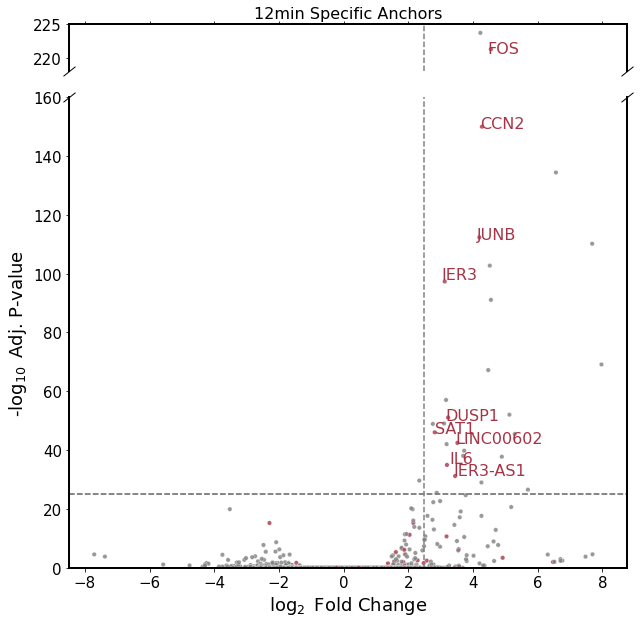

In [10]:
fdr_cutoff = 0.05
l2fc_cutoff = 2.5

#log_fdr_cutoff = -np.log10(fdr_cutoff)
log_fdr_cutoff = 25

height_ratio = [0.1, 1]
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10), gridspec_kw={'hspace': .1, 'height_ratios': height_ratio})

spec1 = df.loc[df['gene_id'].isin(overlap_specific1_gene_id)]
spec2 = df.loc[df['gene_id'].isin(overlap_specific2_gene_id)]

which_df = spec2.copy()

plot_df = df.copy()
plot_df['color_group'] = 'other'
plot_df.loc[plot_df['gene_id'].isin(which_df.gene_id.to_list()), 'color_group'] = 'specific'
plot_df.loc[(plot_df.padj < fdr_cutoff) & (plot_df.color_group != 'specific'), 'color_group'] = 'other'

plot_df['padj'] = plot_df['padj'].apply(lambda x:-np.log10(x))

plot_df.color_group = pd.Categorical(plot_df.color_group, categories=['specific', 'other'])

sns.scatterplot(data=plot_df, x='log2FoldChange', y='padj', hue='color_group', ax=ax1, palette=['#A63446', 'gray'], s=20, alpha=0.8)
sns.scatterplot(data=plot_df, x='log2FoldChange', y='padj', hue='color_group', ax=ax2, palette=['#A63446', 'gray'], s=20, alpha=0.8)

# delete legend
ax1.get_legend().remove()
ax2.get_legend().remove()

cut_points = [160, 218, 225]

ax1.set_ylim(cut_points[1], cut_points[2])  # outliers only
ax2.set_ylim(0, cut_points[0])  # most of the data
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
d = .8  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

x_offset_m = (-.1, .1)
y_offset_m = (-1, 1)
for i,r in plot_df.iterrows():
    x_offset = np.random.uniform(*x_offset_m)
    y_offset = np.random.uniform(*y_offset_m)
    if r['padj'] > log_fdr_cutoff and abs(r['log2FoldChange']) > l2fc_cutoff and r['color_group'] == 'specific' and r['padj'] < cut_points[0]:
        ax2.text(x = r['log2FoldChange'] + x_offset,
                 y = r['padj'] + y_offset,
                 s = r['external_gene_name'], fontsize=16, color = '#A63446')
    elif r['padj'] > log_fdr_cutoff and abs(r['log2FoldChange']) > l2fc_cutoff and r['color_group'] == 'specific' and r['padj'] > cut_points[1]:
        ax1.text(x = r['log2FoldChange'] + x_offset, 
                 y = r['padj'] + y_offset,
                 s=r['external_gene_name'], fontsize=16, color = '#A63446')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

ax1.axvline(l2fc_cutoff,color="grey",linestyle="--")
#ax1.axvline(-l2fc_cutoff,color="grey",linestyle="--")
ax2.axhline(log_fdr_cutoff,color="grey",linestyle="--")
ax2.axvline(l2fc_cutoff,color="grey",linestyle="--")
#ax2.axvline(-l2fc_cutoff,color="grey",linestyle="--")
ax2.axhline(log_fdr_cutoff,color="grey",linestyle="--")

ax1.set_xlabel('')
ax1.set_ylabel('')
#ax2.set_ylabel('-log FDR', fontsize=15)
# make "log" subscript
ax2.set_ylabel(r'-$\log_{10}$ Adj. P-value', fontsize=18)
ax2.set_xlabel(r'$\log_{2}$ Fold Change', fontsize=18)

ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)

for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(2)
    ax2.spines[axis].set_linewidth(2)

ax1.set_title('12min Specific Anchors', fontsize=16)

# plt.xlabel("log2FoldChange")
# plt.ylabel("-logFDR")

fig.savefig('/home/carlos/oldies/manuscripts/review/reworked_figs/volcano_t060rna_t012spec2.png', dpi=300, bbox_inches='tight')
fig.savefig('/home/carlos/oldies/manuscripts/review/reworked_figs/volcano_t060rna_t012spec2.svg', bbox_inches='tight')

### t0-t12 anchors spec2 - t0-t12 rna

In [11]:
deseq_all = pd.read_csv('/home/carlos/oldies/manuscripts/review/t0-t12.all..tsv', sep='\t')
deseq_all['chrom'] = "chr" + deseq_all['chrom']
df = deseq_all.copy()
df.rename(columns={'ensembl_gene_id': 'gene_id'}, inplace=True)

overlap_specific1 = bioframe.overlap(df, specific_anchors1, return_overlap=True)
overlap_specific1.dropna(inplace=True)
overlap_specific1_gene_id = overlap_specific1['gene_id'].unique().tolist()
overlap_specific1['ovelap_size'] = overlap_specific1['overlap_end'] - overlap_specific1['overlap_start']

overlap_specific2 = bioframe.overlap(df, specific_anchors2, return_overlap=True)
overlap_specific2.dropna(inplace=True)
overlap_specific2_gene_id = overlap_specific2['gene_id'].unique().tolist()
overlap_specific2['ovelap_size'] = overlap_specific2['overlap_end'] - overlap_specific2['overlap_start']

overlap_common = bioframe.overlap(df, common_anchors, return_overlap=True)
overlap_common.dropna(inplace=True)
overlap_common_gene_id = overlap_common['gene_id'].unique().tolist()
overlap_common['ovelap_size'] = overlap_common['overlap_end'] - overlap_common['overlap_start']

/tmp/ipykernel_28191/2594785891.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)


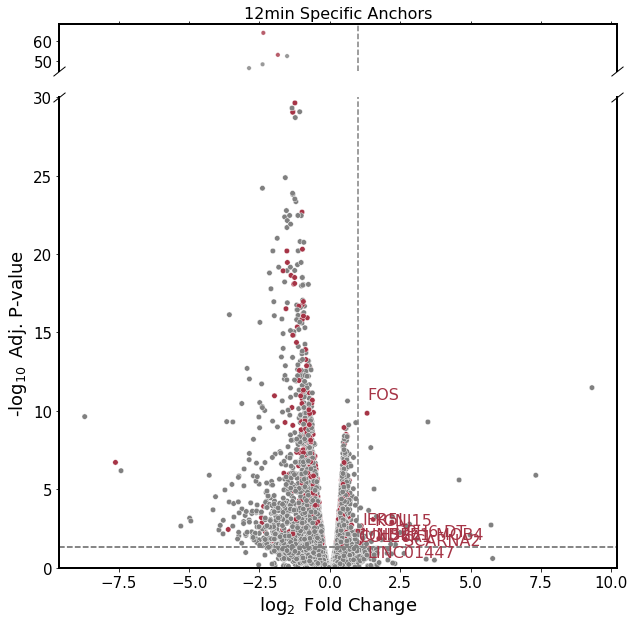

In [12]:
fdr_cutoff = 0.05
l2fc_cutoff = 1
log_fdr_cutoff = -np.log10(fdr_cutoff)
#log_fdr_cutoff = 2

height_ratio = [0.1, 1]
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10), gridspec_kw={'hspace': .1, 'height_ratios': height_ratio})

spec1 = df.loc[df['gene_id'].isin(overlap_specific1_gene_id)]
spec2 = df.loc[df['gene_id'].isin(overlap_specific2_gene_id)]

which_df = spec2.copy()

plot_df = df.copy()
plot_df['color_group'] = 'other'
plot_df.loc[(plot_df['gene_id'].isin(which_df.gene_id.to_list())) & (plot_df.padj < 0.05), 'color_group'] = 'specific'


plot_df['padj'] = plot_df['padj'].apply(lambda x:-np.log10(x))

plot_df.color_group = pd.Categorical(plot_df.color_group, categories=['specific', 'other'])

sns.scatterplot(data=plot_df, x='log2FoldChange', y='padj', hue='color_group', ax=ax1, palette=['#A63446', 'gray'], s=20, alpha=0.8)
sns.scatterplot(data=plot_df, x='log2FoldChange', y='padj', hue='color_group', ax=ax2, palette=['#A63446', 'gray'], s=30)

# delete legend
ax1.get_legend().remove()
ax2.get_legend().remove()

cut_points = [30, 45, 68]

ax1.set_ylim(cut_points[1], cut_points[2])  # outliers only
ax2.set_ylim(0, cut_points[0])  # most of the data
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
d = .8  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

x_offset_m = (-.1, .1)
y_offset_m = (-1, 1)
for i,r in plot_df.iterrows():
    x_offset = np.random.uniform(*x_offset_m)
    y_offset = np.random.uniform(*y_offset_m)
    if r['padj'] > log_fdr_cutoff and r['log2FoldChange'] > l2fc_cutoff and r['color_group'] == 'specific' and r['padj'] < cut_points[0]:
        ax2.text(x = r['log2FoldChange'] + x_offset,
                 y = r['padj'] + y_offset,
                 s = r['external_gene_name'], fontsize=16, color = '#A63446')
    elif r['padj'] > log_fdr_cutoff and r['log2FoldChange'] > l2fc_cutoff and r['color_group'] == 'specific' and r['padj'] > cut_points[1]:
        ax1.text(x = r['log2FoldChange'] + x_offset, 
                 y = r['padj'] + y_offset,
                 s=r['external_gene_name'], fontsize=16, color = '#A63446')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

ax1.axvline(l2fc_cutoff,color="grey",linestyle="--")
#ax1.axvline(-l2fc_cutoff,color="grey",linestyle="--")
ax2.axhline(log_fdr_cutoff,color="grey",linestyle="--")
ax2.axvline(l2fc_cutoff,color="grey",linestyle="--")
# ax2.axvline(-l2fc_cutoff,color="grey",linestyle="--")
ax2.axhline(log_fdr_cutoff,color="grey",linestyle="--")

ax1.set_xlabel('')
ax1.set_ylabel('')
#ax2.set_ylabel('-log FDR', fontsize=15)
# make "log" subscript
ax2.set_ylabel(r'-$\log_{10}$ Adj. P-value', fontsize=18)
ax2.set_xlabel(r'$\log_{2}$ Fold Change', fontsize=18)

ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)

for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(2)
    ax2.spines[axis].set_linewidth(2)

ax1.set_title('12min Specific Anchors', fontsize=16)

# plt.xlabel("log2FoldChange")

fig.savefig('/home/carlos/oldies/manuscripts/review/reworked_figs/volcano_t012rna_t012spec2.png', dpi=300, bbox_inches='tight')
fig.savefig('/home/carlos/oldies/manuscripts/review/reworked_figs/volcano_t012rna_t012spec2.svg', bbox_inches='tight')